In [ ]:
%matplotlib inline
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.0 MB/s eta 0:00:00


In [ ]:
!unzip уран.zip

Archive:  уран.zip
   creating: уран/
   creating: уран/train/
   creating: уран/train/карнотит/
  inflating: уран/train/карнотит/0.03368020829254703.jpg  
  inflating: уран/train/карнотит/0.035368365410240354.jpg  
  inflating: уран/train/карнотит/0.06904066192467428.jpg  
  inflating: уран/train/карнотит/0.07206657443987252.jpg  
  inflating: уран/train/карнотит/0.08185421831053608.jpg  
  inflating: уран/train/карнотит/0.08682517843426052.jpg  
  inflating: уран/train/карнотит/0.08775638684485843.jpg  
  inflating: уран/train/карнотит/0.10340789504933279.jpg  
  inflating: уран/train/карнотит/0.10526005792694049.jpg  
  inflating: уран/train/карнотит/0.11946206505346935.jpg  
  inflating: уран/train/карнотит/0.12079125350794206.jpg  
  inflating: уран/train/карнотит/0.12902104010382642.jpg  
  inflating: уран/train/карнотит/0.14109481362561016.jpg  
  inflating: уран/train/карнотит/0.14367393235220138.jpg  
  inflating: уран/train/карнотит/0.16323378169710412.jpg  
  inflating: уран

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/уран'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



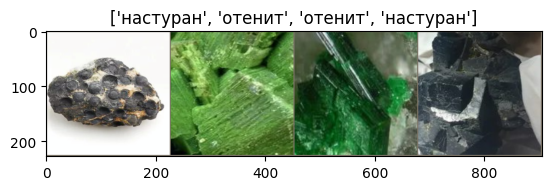

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
ep_loss = []
ep_acc = []


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                ep_loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                ep_acc.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} ground truth {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.7871 Acc: 0.6214
val Loss: 0.2999 Acc: 0.9118

Epoch 1/29
----------
train Loss: 0.4881 Acc: 0.8204
val Loss: 0.2488 Acc: 0.8824

Epoch 2/29
----------
train Loss: 0.4393 Acc: 0.8252
val Loss: 0.3161 Acc: 0.8971

Epoch 3/29
----------
train Loss: 0.4270 Acc: 0.8738
val Loss: 0.3449 Acc: 0.8824

Epoch 4/29
----------
train Loss: 0.6109 Acc: 0.7670
val Loss: 0.5837 Acc: 0.8382

Epoch 5/29
----------
train Loss: 0.5727 Acc: 0.8544
val Loss: 0.3609 Acc: 0.9265

Epoch 6/29
----------
train Loss: 0.5216 Acc: 0.8107
val Loss: 0.1913 Acc: 0.9412

Epoch 7/29
----------
train Loss: 0.4048 Acc: 0.8495
val Loss: 0.2690 Acc: 0.9412

Epoch 8/29
----------
train Loss: 0.4043 Acc: 0.8738
val Loss: 0.2393 Acc: 0.9412

Epoch 9/29
----------
train Loss: 0.3832 Acc: 0.8932
val Loss: 0.2067 Acc: 0.9559

Epoch 10/29
----------
train Loss: 0.5117 Acc: 0.8544
val Loss: 0.1886 Acc: 0.9559

Epoch 11/29
----------
train Loss: 0.2947 Acc: 0.9126
val Loss: 0.1904 Acc: 0.9559

Ep

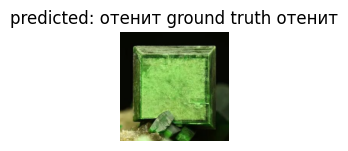

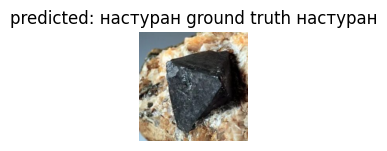

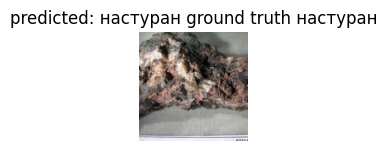

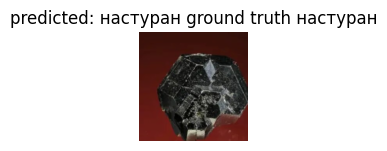

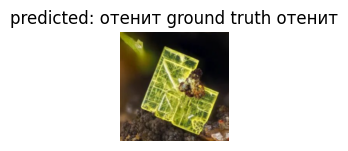

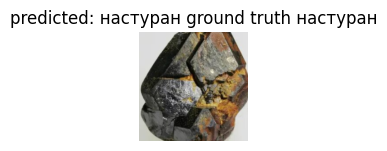

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.



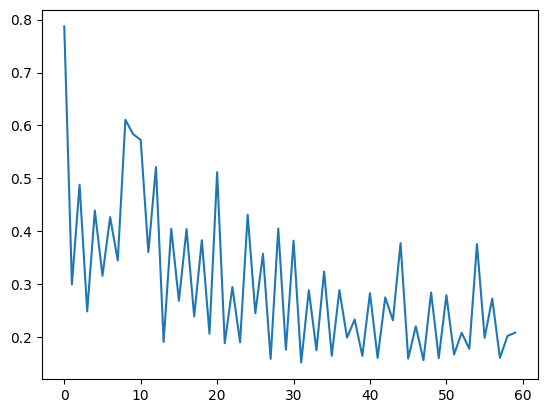

In [ ]:
plt.plot(ep_loss)
plt.show()

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_ft.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/13
----------
train Loss: 0.8825 Acc: 0.5971
val Loss: 0.6718 Acc: 0.6618

Epoch 1/13
----------
train Loss: 0.6230 Acc: 0.7621
val Loss: 0.5672 Acc: 0.7647

Epoch 2/13
----------
train Loss: 0.5764 Acc: 0.7379
val Loss: 0.4545 Acc: 0.8088

Epoch 3/13
----------
train Loss: 0.5523 Acc: 0.7670
val Loss: 0.3818 Acc: 0.8676

Epoch 4/13
----------
train Loss: 0.5919 Acc: 0.7573
val Loss: 0.4154 Acc: 0.9265

Epoch 5/13
----------
train Loss: 0.7247 Acc: 0.6990
val Loss: 0.6504 Acc: 0.7206

Epoch 6/13
----------
train Loss: 0.6207 Acc: 0.7816
val Loss: 0.2721 Acc: 0.9118

Epoch 7/13
----------
train Loss: 0.4152 Acc: 0.8592
val Loss: 0.2681 Acc: 0.8824

Epoch 8/13
----------
train Loss: 0.3861 Acc: 0.8301
val Loss: 0.2572 Acc: 0.8676

Epoch 9/13
----------
train Loss: 0.4890 Acc: 0.8107
val Loss: 0.2747 Acc: 0.8971

Epoch 10/13
----------
train Loss: 0.3987 Acc: 0.8204
val Loss: 0.3025 Acc: 0.8824

Epoch 11/13
----------
train Loss: 0.4393 Acc: 0.8350
val Loss: 0.2631 Acc: 0.8971

Ep

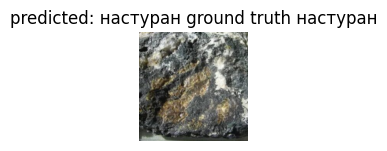

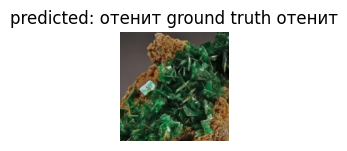

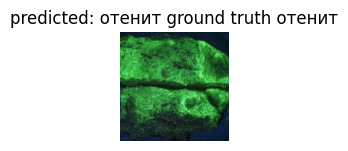

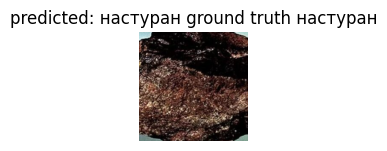

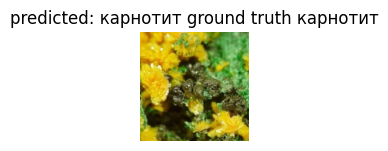

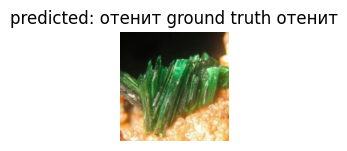

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

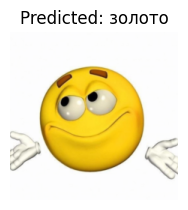

In [ ]:
visualize_model_predictions(
    model_conv,
    '/content/гений какой-то.jpg'
)

visualize_model_predictions(
    model_conv,
    '/content/АХАХА БОЛТ.jpg'
)

plt.ioff()
plt.show()